In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, precision_score, recall_score

In [2]:
notebook_name = '8_classes_EfficientNetV2B0_96x96_bs_256_weighted'

In [3]:
train_dir = '../data/images/train'
val_dir = '../data/images/val'
test_dir = '../data/images/test'

train_df = pd.read_csv('../data/majority_train.csv')
val_df = pd.read_csv('../data/majority_val.csv')
test_df = pd.read_csv('../data/majority_test.csv')

In [4]:
train_df

,filename,class
0,fer0000001.png,neutral
1,fer0000002.png,neutral
2,fer0000004.png,neutral
3,fer0000005.png,neutral
4,fer0000006.png,sadness
...,...,...
25040,fer0028633.png,fear
25041,fer0028634.png,anger
25042,fer0028635.png,sadness
25043,fer0028636.png,neutral


In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.05,
    shear_range=np.rad2deg(np.arctan(0.05)),  # used to set the value by fraction instead of an angle
    horizontal_flip=True,
    fill_mode='reflect',
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

target_size = (96, 96)
interpolation = 'bilinear'
color_mode = 'grayscale'
batch_size = 256

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

Found 25045 validated image filenames belonging to 8 classes.
Found 3191 validated image filenames belonging to 8 classes.
Found 3137 validated image filenames belonging to 8 classes.


In [6]:
labels = list(train_generator.class_indices.keys())

In [7]:
labels

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutral',
 'sadness',
 'surprise']

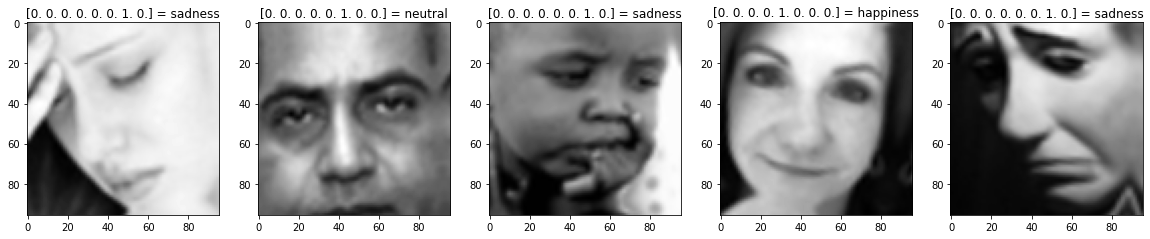

In [8]:
data = next(train_generator)

plt.figure(figsize=[20, 20])

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(f'{data[1][i]} = {labels[np.argmax(data[1][i])]}')
    plt.imshow(data[0][i], cmap='gray')

plt.show()

In [9]:
model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    input_shape=(96, 96, 1),
    weights=None,
    classes=8,
)

In [10]:
model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 1)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 32)   288         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 32)   128         ['stem_conv[0][0]']              
                                                                                  

                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 12, 12, 192)  9216        ['block3b_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 12, 12, 192)  768        ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 12, 12, 192)  0          ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_dwconv2 (DepthwiseConv  (None, 6, 6, 192)   1728        ['block4a_expand_activation[0][0]
 2D)      

 block4c_bn (BatchNormalization  (None, 6, 6, 384)   1536        ['block4c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 6, 6, 384)   0           ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_se_squeeze (GlobalAver  (None, 384)         0           ['block4c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 384)    0           ['block4c_se_squeeze[0][0]']     
          

                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 6, 6, 672)    0           ['block5b_activation[0][0]',     
                                                                  'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 6, 6, 112)    75264       ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_project_bn (BatchNorma  (None, 6, 6, 112)   448         ['block5b_project_conv[0][0]']   
 lization)                                                                                        
          

 lization)                                                                                        
                                                                                                  
 block5d_add (Add)              (None, 6, 6, 112)    0           ['block5d_project_bn[0][0]',     
                                                                  'block5c_add[0][0]']            
                                                                                                  
 block5e_expand_conv (Conv2D)   (None, 6, 6, 672)    75264       ['block5d_add[0][0]']            
                                                                                                  
 block5e_expand_bn (BatchNormal  (None, 6, 6, 672)   2688        ['block5e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5e_e

                                                                                                  
 block6b_dwconv2 (DepthwiseConv  (None, 3, 3, 1152)  10368       ['block6b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 3, 3, 1152)  4608        ['block6b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 3, 3, 1152)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_s

                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_s

                                                                                                  
 block6f_se_excite (Multiply)   (None, 3, 3, 1152)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, 3, 3, 192)    221184      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 3, 3, 192)   768         ['block6f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6f_add (Add)              (None, 3, 3, 192)    0           ['block6f_project_bn[0][0]',     
          

 block6h_add (Add)              (None, 3, 3, 192)    0           ['block6h_project_bn[0][0]',     
                                                                  'block6g_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, 3, 3, 1280)   245760      ['block6h_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 3, 3, 1280)   5120        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 3, 3, 1280)   0           ['top_bn[0][0]']                 
                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 1280)        0           ['top_activation[0][0]']         
 2D)      

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
  )

In [12]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=10,
    verbose=2,
)

In [13]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=20,
    restore_best_weights=True,
    verbose=2,
)

In [14]:
min_loss_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/min_loss.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=2,
)

In [15]:
max_accuracy_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_accuracy.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [16]:
max_precision_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_precision.h5',
    monitor='val_precision',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [17]:
max_recall_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_recall.h5',
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [18]:
labels

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutral',
 'sadness',
 'surprise']

In [19]:
class_weights = {
    0: 1.0,
    1: 5.0,
    2: 4.0,
    3: 2.0,
    4: 1.0,
    5: 0.75,
    6: 1.0,
    7: 1.0,
}

In [20]:
fit_history = model.fit(
    train_generator,
    epochs=300,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[
        lr_callback,
        early_stop_callback,
        min_loss_callback,
        max_accuracy_callback,
        max_precision_callback,
        max_recall_callback,
    ],
    verbose=2,
)

Epoch 1/300

Epoch 1: val_loss improved from inf to 2.36009, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\min_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.27672, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_accuracy.h5

Epoch 1: val_precision improved from -inf to 0.26644, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_precision.h5

Epoch 1: val_recall improved from -inf to 0.02413, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_recall.h5
98/98 - 55s - loss: 2.7101 - accuracy: 0.3104 - precision: 0.2839 - recall: 0.0443 - val_loss: 2.3601 - val_accuracy: 0.2767 - val_precision: 0.2664 - val_recall: 0.0241 - lr: 0.0100 - 55s/epoch - 561ms/step
Epoch 2/300

Epoch 2: val_loss improved from 2.36009 to 1.72009, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\min_loss.h5

Epoch 2: val_accuracy improved from 0.27672 to 0.36979, saving model


Epoch 14: val_precision did not improve from 0.74678

Epoch 14: val_recall improved from 0.55186 to 0.55374, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_recall.h5
98/98 - 38s - loss: 0.9912 - accuracy: 0.6809 - precision: 0.7855 - recall: 0.5550 - val_loss: 1.0081 - val_accuracy: 0.6562 - val_precision: 0.7449 - val_recall: 0.5537 - lr: 0.0100 - 38s/epoch - 391ms/step
Epoch 15/300

Epoch 15: val_loss improved from 1.00814 to 0.86217, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\min_loss.h5

Epoch 15: val_accuracy improved from 0.65622 to 0.70229, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_accuracy.h5

Epoch 15: val_precision improved from 0.74678 to 0.78889, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_precision.h5

Epoch 15: val_recall improved from 0.55374 to 0.60075, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_recall.h5
98/9

98/98 - 38s - loss: 0.6868 - accuracy: 0.7683 - precision: 0.8278 - recall: 0.7019 - val_loss: 0.6661 - val_accuracy: 0.7656 - val_precision: 0.8121 - val_recall: 0.7029 - lr: 0.0100 - 38s/epoch - 388ms/step
Epoch 29/300

Epoch 29: val_loss improved from 0.66613 to 0.63807, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\min_loss.h5

Epoch 29: val_accuracy improved from 0.76559 to 0.77311, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_accuracy.h5

Epoch 29: val_precision improved from 0.81829 to 0.81844, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_precision.h5

Epoch 29: val_recall improved from 0.70291 to 0.72046, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_recall.h5
98/98 - 38s - loss: 0.6703 - accuracy: 0.7794 - precision: 0.8353 - recall: 0.7172 - val_loss: 0.6381 - val_accuracy: 0.7731 - val_precision: 0.8184 - val_recall: 0.7205 - lr: 0.0100 - 38s/epoch - 392m

Epoch 44/300

Epoch 44: val_loss improved from 0.57990 to 0.57778, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\min_loss.h5

Epoch 44: val_accuracy did not improve from 0.80069

Epoch 44: val_precision did not improve from 0.83493

Epoch 44: val_recall did not improve from 0.77029
98/98 - 37s - loss: 0.5443 - accuracy: 0.8097 - precision: 0.8510 - recall: 0.7665 - val_loss: 0.5778 - val_accuracy: 0.7800 - val_precision: 0.8168 - val_recall: 0.7543 - lr: 0.0100 - 37s/epoch - 381ms/step
Epoch 45/300

Epoch 45: val_loss did not improve from 0.57778

Epoch 45: val_accuracy did not improve from 0.80069

Epoch 45: val_precision did not improve from 0.83493

Epoch 45: val_recall did not improve from 0.77029
98/98 - 37s - loss: 0.5473 - accuracy: 0.8107 - precision: 0.8487 - recall: 0.7687 - val_loss: 0.6096 - val_accuracy: 0.7910 - val_precision: 0.8282 - val_recall: 0.7568 - lr: 0.0100 - 37s/epoch - 377ms/step
Epoch 46/300

Epoch 46: val_loss did not improve from 


Epoch 61: val_precision did not improve from 0.83863

Epoch 61: val_recall did not improve from 0.77719
98/98 - 37s - loss: 0.4579 - accuracy: 0.8347 - precision: 0.8623 - recall: 0.8073 - val_loss: 0.7966 - val_accuracy: 0.7277 - val_precision: 0.7718 - val_recall: 0.6838 - lr: 0.0100 - 37s/epoch - 377ms/step
Epoch 62/300

Epoch 62: val_loss improved from 0.56188 to 0.54965, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\min_loss.h5

Epoch 62: val_accuracy improved from 0.81040 to 0.81134, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_accuracy.h5

Epoch 62: val_precision did not improve from 0.83863

Epoch 62: val_recall improved from 0.77719 to 0.78283, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_recall.h5
98/98 - 38s - loss: 0.4562 - accuracy: 0.8362 - precision: 0.8649 - recall: 0.8051 - val_loss: 0.5497 - val_accuracy: 0.8113 - val_precision: 0.8385 - val_recall: 0.7828 - lr: 0.0100 - 38s/ep


Epoch 77: val_precision improved from 0.84962 to 0.85500, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_precision.h5

Epoch 77: val_recall improved from 0.80915 to 0.82043, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_recall.h5
98/98 - 38s - loss: 0.3955 - accuracy: 0.8533 - precision: 0.8744 - recall: 0.8314 - val_loss: 0.5021 - val_accuracy: 0.8389 - val_precision: 0.8550 - val_recall: 0.8204 - lr: 0.0100 - 38s/epoch - 388ms/step
Epoch 78/300

Epoch 78: val_loss improved from 0.49517 to 0.47963, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\min_loss.h5

Epoch 78: val_accuracy did not improve from 0.83892

Epoch 78: val_precision did not improve from 0.85500

Epoch 78: val_recall did not improve from 0.82043
98/98 - 37s - loss: 0.3301 - accuracy: 0.8787 - precision: 0.8950 - recall: 0.8595 - val_loss: 0.4796 - val_accuracy: 0.8367 - val_precision: 0.8524 - val_recall: 0.8201 - lr: 1.0000e-03 - 3


Epoch 93: val_accuracy did not improve from 0.84331

Epoch 93: val_precision did not improve from 0.85899

Epoch 93: val_recall improved from 0.83234 to 0.83359, saving model to ../models/EfficientNetV2B0_96x96_256_weighted_manually_2\max_recall.h5
98/98 - 37s - loss: 0.2477 - accuracy: 0.9007 - precision: 0.9124 - recall: 0.8912 - val_loss: 0.4818 - val_accuracy: 0.8421 - val_precision: 0.8542 - val_recall: 0.8336 - lr: 1.0000e-04 - 37s/epoch - 381ms/step
Epoch 94/300

Epoch 94: val_loss did not improve from 0.47609

Epoch 94: val_accuracy did not improve from 0.84331

Epoch 94: val_precision did not improve from 0.85899

Epoch 94: val_recall did not improve from 0.83359
98/98 - 37s - loss: 0.2449 - accuracy: 0.9018 - precision: 0.9127 - recall: 0.8924 - val_loss: 0.4856 - val_accuracy: 0.8405 - val_precision: 0.8528 - val_recall: 0.8336 - lr: 1.0000e-04 - 37s/epoch - 377ms/step
Epoch 95/300

Epoch 95: val_loss did not improve from 0.47609

Epoch 95: val_accuracy did not improve from

In [21]:
def draw_graphics(fit_history, metric_name):
    history = fit_history.history
    
    metric = history[metric_name]
    val_metric = history[f'val_{metric_name}']
    
    epochs = range(1, len(metric) + 1)

    plt.plot(epochs, metric, 'b', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, 'r', label=f'Validation {metric_name}')
    
    plt.title(f'Training and validation {metric_name}')
    plt.xlabel('epochs')
    plt.ylabel(f'{metric_name}')
    plt.legend()
    plt.show()

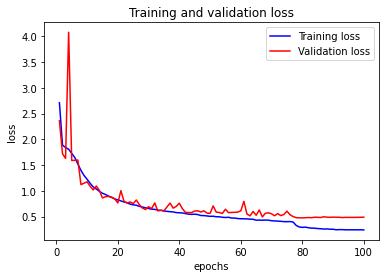

In [22]:
draw_graphics(fit_history, 'loss')

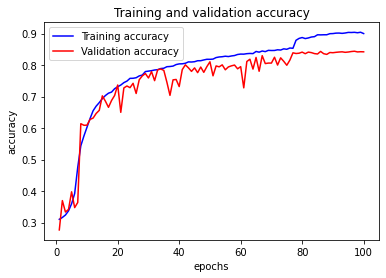

In [23]:
draw_graphics(fit_history, 'accuracy')

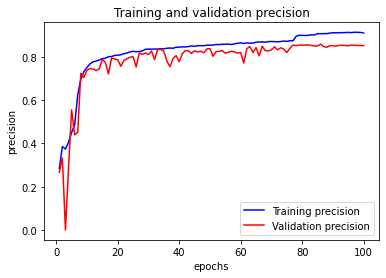

In [24]:
draw_graphics(fit_history, 'precision')

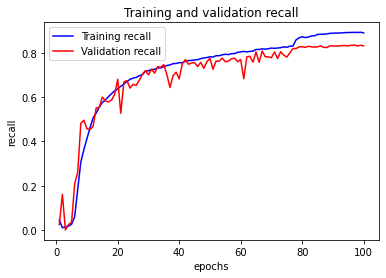

In [25]:
draw_graphics(fit_history, 'recall')

In [26]:
x_test = []
y_test = []

for image_name, emotion in test_df.values:
    image = tf.keras.preprocessing.image.load_img(
        os.path.join(test_dir, image_name),
        target_size=target_size,
        interpolation=interpolation,
        color_mode=color_mode,
    )
    
    x_test.append(tf.keras.preprocessing.image.img_to_array(image))
    y_test.append(labels.index(emotion))
        
x_test = np.array(x_test)
y_test = np.array(y_test)

In [27]:
def draw_confusion_matrix(y_true, y_pred, labels):
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    display = ConfusionMatrixDisplay(cm, display_labels=labels)

    _, ax = plt.subplots(figsize=(10, 10))
    display.plot(cmap=plt.cm.Blues, ax=ax)
    plt.show()

In [28]:
def compute_metrics(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 score: {2 * (precision * recall) / (precision + recall) * 100:.2f}%')

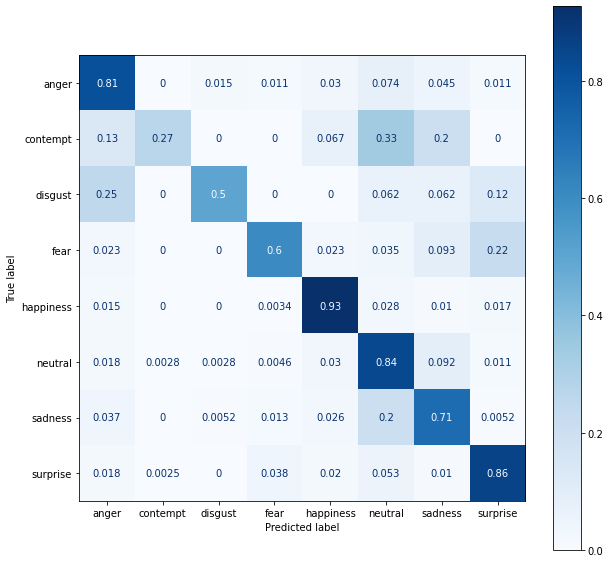

Accuracy: 83.77%
Precision: 71.17%
Recall: 69.01%
F1 score: 70.08%


In [29]:
min_loss_model = tf.keras.models.load_model(f'../models/{notebook_name}/min_loss.h5')
y_pred = min_loss_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

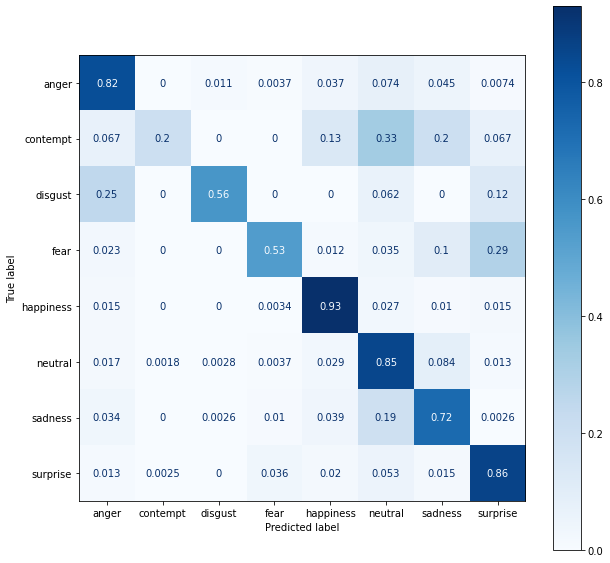

Accuracy: 84.25%
Precision: 72.75%
Recall: 68.49%
F1 score: 70.55%


In [30]:
# best
max_accuracy_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_accuracy.h5')
y_pred = max_accuracy_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

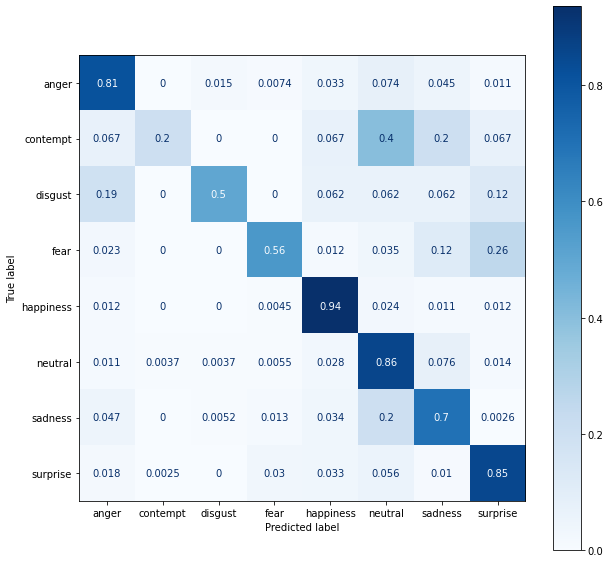

Accuracy: 84.32%
Precision: 69.71%
Recall: 67.70%
F1 score: 68.69%


In [31]:
max_precision_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_precision.h5')
y_pred = max_precision_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

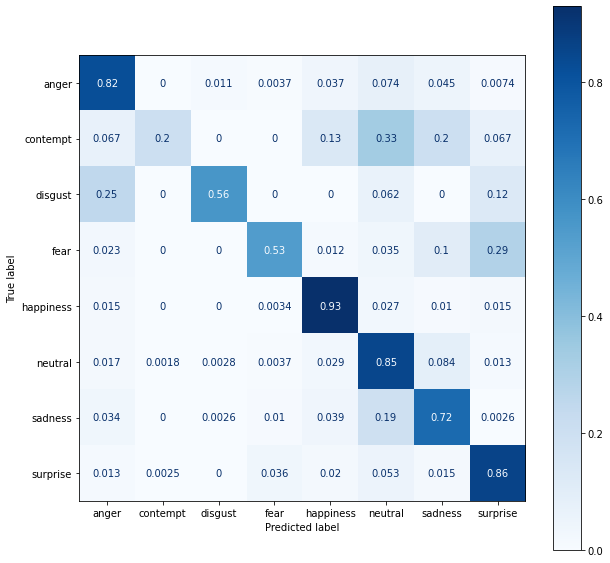

Accuracy: 84.25%
Precision: 72.75%
Recall: 68.49%
F1 score: 70.55%


In [32]:
max_recall_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_recall.h5')
y_pred = max_recall_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)